# Re-implementation of GBF in python

In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import sys
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.io

sys.path.insert(0, '../baselines/gbf')
from gbf_utils import SARBM3D, SoftClassifier, GBF

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[CpuDevice(id=0)]


In [20]:
def T(sar):
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar


def Norm(sar):
    sar = jnp.array(sar)
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    return sar


def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return jnp.dot(rgb[..., :3], jnp.array([1./3.] * 3))

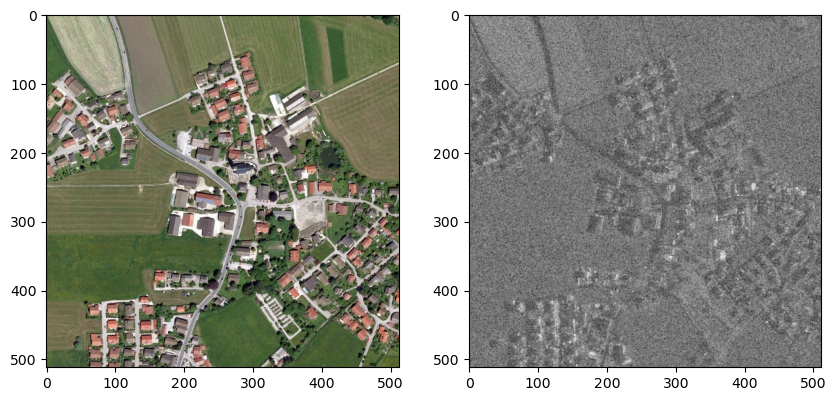

In [3]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

### Apply SARBM3D

In [4]:
sarbm3d = SARBM3D(matlab_script_path='./../../SARBM3D_v10_linux64/SARBM3D_v10.m')

sar_filtered_sarbm3d = sarbm3d.filter(noisy, L=1)

In [19]:
sar_filtered_sarbm3d.min(), sar_filtered_sarbm3d.max(), noisy.min(), noisy.max()

(Array(5.6867237, dtype=float32),
 Array(16.787891, dtype=float32),
 np.float64(0.0),
 np.float64(13214.244140625))

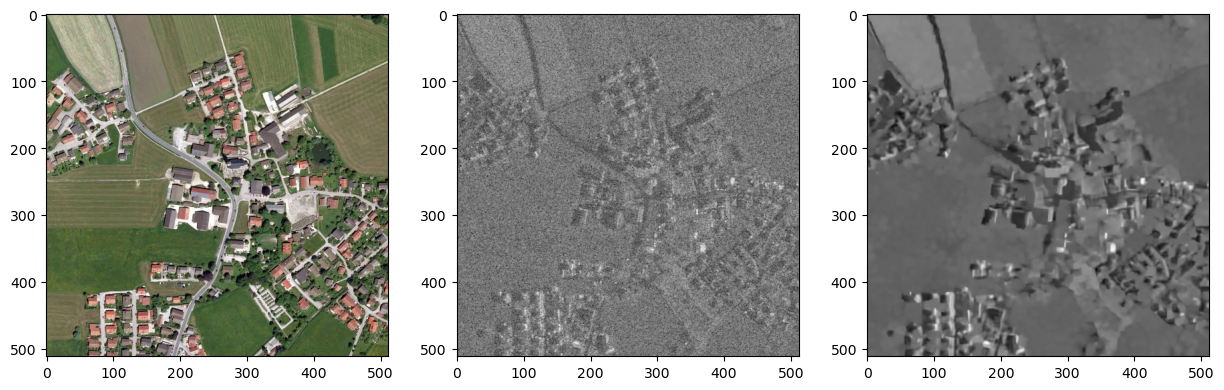

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered_sarbm3d), cmap='gray')

### Soft classifier 

In [6]:
soft_classifier = SoftClassifier()

weights = soft_classifier.compute_weight(noisy, N=np.arange(7, 63, 2).tolist())

100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


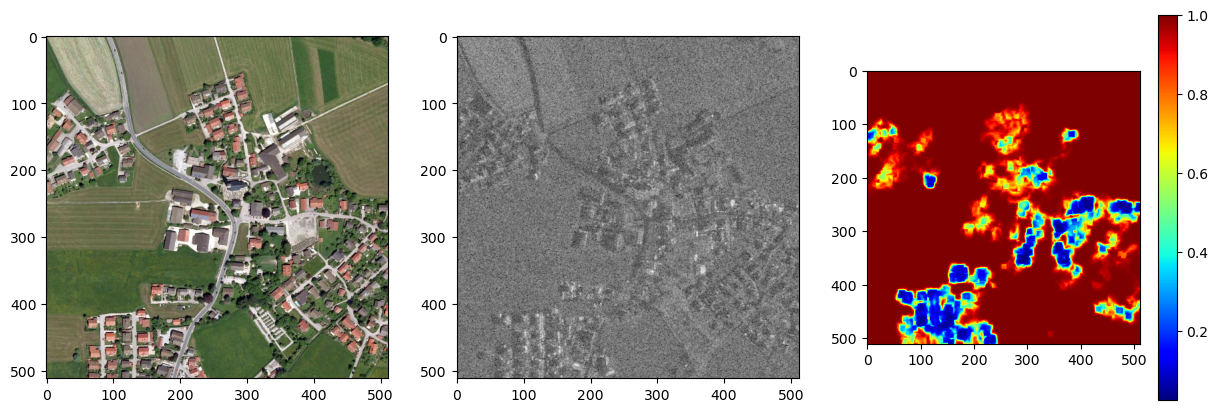

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(weights, cmap='jet')
plt.colorbar()

### GBF

In [8]:
gbf = GBF()

sar_filtered_gbf = gbf.filter(T(noisy).squeeze(), rgb2gray(guide))

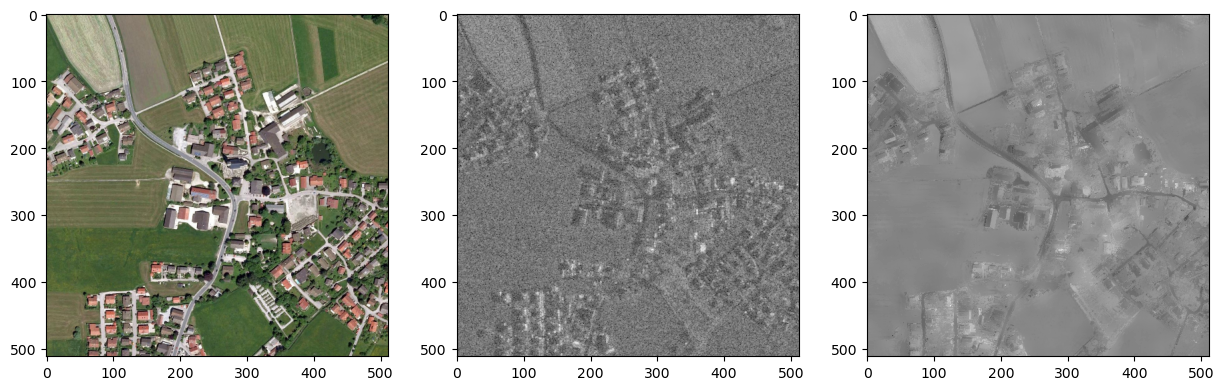

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered_gbf, cmap='gray')

### Despeckling

In [21]:
uO = sar_filtered_gbf.squeeze()
uS = sar_filtered_sarbm3d.squeeze()
ft = weights

sar_despeckled = ft * Norm(uO) + (1 - ft) * Norm(uS)

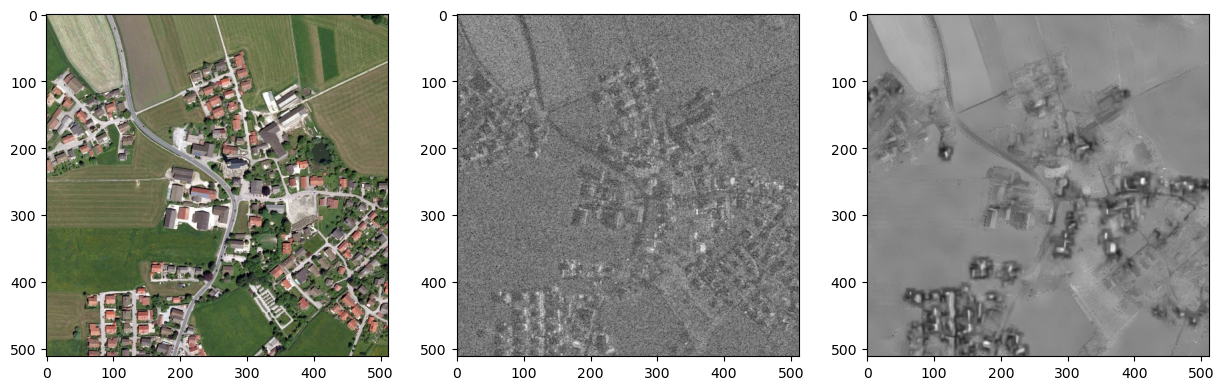

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_despeckled, cmap='gray')

In [18]:
uO.min(), uO.max(), uS.min(), uS.max()

(Array(0.17375906, dtype=float32),
 Array(0.7118667, dtype=float32),
 Array(5.6867237, dtype=float32),
 Array(16.787891, dtype=float32))